<a href="https://colab.research.google.com/github/Nix07/DenseNet-on-CIFAR10/blob/master/DenseNet_for_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import io
import math
import pickle
import time
import numpy as np

import torch
import torch.onnx
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable

## DenseNet Model

In [ ]:
class Bottleneck(nn.Module):
    """
    A class used to represent the bottleneck architecture.

    Attributes
    ----------
    in_planes   => Number on input channels
    growth_rate => Fixed number of feature maps in the dense block
    """

    def __init__(self, in_planes, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, 4*growth_rate, kernel_size=1, 
                               bias=False)
        self.bn2 = nn.BatchNorm2d(4*growth_rate)
        self.conv2 = nn.Conv2d(4*growth_rate, growth_rate, kernel_size=3, 
                               padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out = torch.cat([out,x], 1)
        return out

In [ ]:
class Transition(nn.Module):
    """
    A class to represent the Transition Block which reduces the features maps
    between two Dense Blocks. It acts as down sampler.

    Arguments
    ---------
    in_planes  => Number of input channels.
    out_planes => Number of channels produced by the convolution.
    """

    def __init__(self, in_planes, out_planes):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_planes)
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False)

    def forward(self, x):
        out = self.conv(F.relu(self.bn(x)))
        out = F.avg_pool2d(out, 2)
        return out

In [ ]:
class DenseNet(nn.Module):
    """
    A class to represent the DenseNet model.

    Arguments
    ---------
    denseLayer  => Represents the type of dense layer used in Dense Block, i.e. Bottleneck.
    nblocks     => Number of layers in each Dense Block.
    growth_rate => Fixed number of feature maps in the dense block.
    reduction   => Reduction factor for number of feature maps.
    num_classes => Number of output classes.
    """

    def __init__(self, denseLayer, nblocks, growth_rate=12, reduction=0.5, 
                 num_classes=10):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate

        num_planes = 2*growth_rate

        # Initial Convolution layer of DenseNet.
        self.conv1 = nn.Conv2d(3, num_planes, kernel_size=3, padding=1, 
                               bias=False)

        ## A first pair of Dense Block and Transition Block where the number of
        ## layers in the Dense Block are 6.
        self.dense1 = self._make_dense_layers(denseLayer, num_planes, nblocks[0])
        num_planes += nblocks[0]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans1 = Transition(num_planes, out_planes)
        num_planes = out_planes

        ## A second pair of Dense Block and Transition Block where the number of
        ## layers in the Dense Block are 12.
        self.dense2 = self._make_dense_layers(denseLayer, num_planes, nblocks[1])
        num_planes += nblocks[1]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans2 = Transition(num_planes, out_planes)
        num_planes = out_planes

        ## A third pair of Dense Block and Transition Block where the number of
        ## layers in the Dense Block are 24.
        self.dense3 = self._make_dense_layers(denseLayer, num_planes, nblocks[2])
        num_planes += nblocks[2]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans3 = Transition(num_planes, out_planes)
        num_planes = out_planes

        ## Final Dense Block with 16 layers.
        self.dense4 = self._make_dense_layers(denseLayer, num_planes, nblocks[3])
        num_planes += nblocks[3]*growth_rate

        ## Batch Normalization followed by Fully Connected layer for image classification.
        self.bn = nn.BatchNorm2d(num_planes)
        self.linear = nn.Linear(num_planes, num_classes)


    def _make_dense_layers(self, denseLayer, in_planes, nblock):
        """
        A method to construct Dense Block by utilizing the Bottleneck architecture.

        Arguements
        ----------
        denseLayer => Name of the architecture to be used for constructing layers of Dense Block, i.e. Bottleneck.
        in_planes  => Number of input channels.
        nblock     => Number of layers to be constructed for a Dene Block.
        """
        layers = []
        for i in range(nblock):
            layers.append(denseLayer(in_planes, self.growth_rate))
            in_planes += self.growth_rate
        return nn.Sequential(*layers)


    def forward(self, x):
        """
        A method to for compute the forward propagation of the DenseNet model.

        Arguments
        ---------
        x => Input to the model.
        """
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.trans3(self.dense3(out))
        out = self.dense4(out)
        out = F.avg_pool2d(F.relu(self.bn(out)), 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


# CIFAR10 Dataset

This section:

1.   Downloads the CIFAR10 dataset from torchvision.datasets.
2.   Performs pre-processing on downloaded image data by converting to tensors and normalizing them.





In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Model Training

In [ ]:
# GPU Details
!nvidia-smi

Mon Jul 13 14:19:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    29W /  70W |   1381MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def loss_function(outputs, labels):
  """
  A function to compute the loss between predicted and true labels.

  Arguements
  ----------
  outputs => Model predictions
  labels  => True labels.
  """

  return nn.CrossEntropyLoss()(outputs, labels)

In [ ]:
def training_loop_function(data_loader, model, optimizer, device):
  """
  A function to implement the training loop over the training dataset.
  
  Arguments
  ---------
  data_loader => Data Loader containing the training data.
  model       => DenseNet model to be trained.
  optimizer   => Optimizer for the loss function.
  device      => Represents the device used for training (CPU/GPU).
  """

  model.train()

  running_loss = 0.0
  for bi, data in enumerate(data_loader):
    inputs, labels = data
    inputs = Variable(inputs).to(device)
    labels = Variable(labels).to(device)

    optimizer.zero_grad()

    outputs = model(inputs)
    
    loss = loss_function(outputs, labels)
    loss.backward()

    optimizer.step()

    running_loss += loss.item()
    if bi%50 == 0 and bi!=0:
      temp = f'Batch index = {bi}\tLoss = {running_loss/50}'
      print(temp)

      f1 = open('loss.txt', 'a+')
      temp = temp + '\n'
      f1.write(temp)
      f1.close()

      running_loss = 0.0


In [ ]:
def testing_loop_function(data_loader, model, device):
  """
  A function to implement the testing loop over the test dataset and computing
  the accuracy of the trained model.

  Arguments
  ---------
  data_loader => Data Loader containing the test dataset.
  model       => Trained model to be tested.
  device      => Represents the device used for testing (CPU/GPU).
  """

  model.eval()

  correct = 0
  total = 0

  for data in data_loader:
    inputs, labels = data
    inputs = Variable(inputs).to(device)

    outputs = model(inputs)
    outputs = outputs.cpu()

    _, predicted = torch.max(outputs.data, 1)
    # print(f'Predicted = {predicted}\nLabels = {labels}')
    total += labels.size(0)
    correct += (predicted == labels).sum()

  print(f'\nCorrect = {correct}\tTotal = {total}')
  if total != 0:
    accuracy = (float(correct)/total)*100
  else:
    accuracy = 0

  print(f'Accuracy = {accuracy}%\n')
  return accuracy

In [ ]:
# Hyperparameters
TRAIN_BATCH_SIZE = 20
TEST_BATCH_SIZE = 10
EPOCHS = 10
NUMBER_OF_CLASSES = 10
LEARNING_RATE = 0.001

In [ ]:
# Constructing training and testing data loader. 
train_data_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = TRAIN_BATCH_SIZE,
    shuffle = True, 
    num_workers = 4)

test_data_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = TEST_BATCH_SIZE,
    shuffle = True,
    num_workers = 4)

In [ ]:
print(f'Training set size = {len(train_data_loader)}')
print(f'Testing set size = {len(test_data_loader)}')

Training set size = 2500
Testing set size = 1000


In [ ]:
# Selecting the device.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device = {device}')

Device = cuda:0


In [ ]:
model = DenseNet(Bottleneck, [6,12,24,16], growth_rate=12)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [ ]:
start = time.time()
for epoch in range(EPOCHS):
  training_loop_function(train_data_loader, model, optimizer, device)
  
  accuracy = testing_loop_function(test_data_loader, model, device)
  testing_accuracies.append(accuracy)
  torch.save(model, 'Pre-Trained DenseNet Models/Epoch' + str(epoch) + '.bin')

end = time.time()
print(f'Total time = {(end-start)/60} minutes')

Batch index = 50	Loss = 1.2379081773757934
Batch index = 100	Loss = 1.0912002265453338
Batch index = 150	Loss = 1.1317026901245117
Batch index = 200	Loss = 1.2060582339763641
Batch index = 250	Loss = 1.0855933332443237
Batch index = 300	Loss = 1.1300887978076934
Batch index = 350	Loss = 1.0923901629447936
Batch index = 400	Loss = 1.1051630532741548
Batch index = 450	Loss = 1.0490447652339936
Batch index = 500	Loss = 1.0308772397041321
Batch index = 550	Loss = 1.0134735119342804
Batch index = 600	Loss = 1.0888130581378936
Batch index = 650	Loss = 1.0306979483366012
Batch index = 700	Loss = 0.9881055080890655
Batch index = 750	Loss = 0.9934396374225617
Batch index = 800	Loss = 0.977533872127533
Batch index = 850	Loss = 0.9787932795286178
Batch index = 900	Loss = 0.9620926904678345
Batch index = 950	Loss = 0.9869308066368103
Batch index = 1000	Loss = 1.0038587683439255
Batch index = 1050	Loss = 0.9163251012563706
Batch index = 1100	Loss = 0.9379232889413833
Batch index = 1150	Loss = 1.009

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type DenseNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Bottleneck. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Transition. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Batch index = 50	Loss = 0.7555076712369919
Batch index = 100	Loss = 0.7355345523357392
Batch index = 150	Loss = 0.6836469519138336
Batch index = 200	Loss = 0.8202556383609771
Batch index = 250	Loss = 0.7304655772447586
Batch index = 300	Loss = 0.7895811396837235
Batch index = 350	Loss = 0.7737535828351975
Batch index = 400	Loss = 0.7411657029390335
Batch index = 450	Loss = 0.7669126921892166
Batch index = 500	Loss = 0.7407006359100342
Batch index = 550	Loss = 0.7643030899763107
Batch index = 600	Loss = 0.7670738053321838
Batch index = 650	Loss = 0.6904565501213074
Batch index = 700	Loss = 0.748568748831749
Batch index = 750	Loss = 0.7275595307350159
Batch index = 800	Loss = 0.7869824385643005
Batch index = 850	Loss = 0.7101641434431076
Batch index = 900	Loss = 0.7383596873283387
Batch index = 950	Loss = 0.6900921958684921
Batch index = 1000	Loss = 0.695888090133667
Batch index = 1050	Loss = 0.6431792521476746
Batch index = 1100	Loss = 0.6776600253582
Batch index = 1150	Loss = 0.7169932

# Result and Analysis

In [ ]:
f1 = open('loss.txt', 'r')
data = f1.read().split('\n')
f1.close()

In [ ]:
y = []

for each in data:
  each = each.split('\t')
  temp = each[1].split(' = ')[1]
  y.append(float(temp))

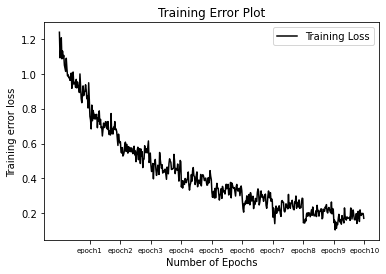

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

x = range(len(y))
x_epoch = [z for z in range(1, len(y)+1) if (z%49)==0]
x_ticks_labels = ['epoch' + str(x) for x in range(1, 11)]

plt.figure(1)
plt.plot(x, y, color='k', label="Training Loss")
plt.xticks(x_epoch, x_ticks_labels, fontsize=7)
plt.title("Training Error Plot")
plt.ylabel("Training error loss")
plt.xlabel("Number of Epochs")
plt.legend()
plt.savefig('training.png', dpi=300, figsize=(10, 20))
plt.show()

In [ ]:
x_epoch

[99, 198, 297, 396]

# Model Latency

This section computes the model latency.

Instead of computing the latency based on a single batch, it is computed by averaging the latencies of 10 batches, to get a robust value.

In [ ]:
trained_model = torch.load('/content/DenseNETforCIFAR10-8.bin')
trained_model.eval();

In [ ]:
# Batch Size = 1 image (3x32x32)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
random_inputs = torch.randn(10, 1, 3, 32, 32)
random_inputs = random_inputs.to(device)

total_time = 0
for input in random_inputs:
  start = time.time()
  outputs = trained_model(input)
  end = time.time()

  total_time += end - start

print(f'Latency of the model for inferencing a single image\'s class using \
        Tesla K80 = {total_time/10} seconds')

Device: cuda:0
Latency of the model for inferencing a single image's class using Tesla K80 = 0.03198542594909668 seconds


# Exporting PyTorch Model to ONNX

In [ ]:
model = torch.load('/content/DenseNETforCIFAR10-8.bin')
model.eval();

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

x = torch.randn(1, 3, 32, 32)
x = x.to(device)
torch_out = model(x)

torch.onnx.export(model, x, "denseNet.onnx")